# EDGARのデータを取得する
<iframe width="560" height="315" src="https://www.youtube.com/embed/twu1fOw7ZBo" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

EDGAR(Electronic Data Gathering, Analysis, and Retrieval system)とは、米国の証券取引委員会の運営するサイトです。
米国の法による法定開示書類が管理されています。ここでは米国企業の財務諸表も管理されています。

今回は指定した企業の財務諸表を取得して、データをプロットしてみようと思います。

In [1]:
import os
from sec_edgar_downloader import Downloader

dl = Downloader("./data/")
ticker_symbol = "MSFT"

if os.path.exists(f"./data/sec-edgar-filings/{ticker_symbol}/10-K/"):
    print("ダウンロード済みです。")
elif dl.get("10-K", ticker_symbol, after="2021-01-01", before="2021-12-31") > 0:
    print("ダウンロードに成功しました。")
else:
    print("ダウンロードに失敗しました。")

ダウンロード済みです。


## 10-Kに含まれる表を抜き出す
pandasの`read_html`を用いることでテーブルをDataFrameの形で抜き出すことができます。

```{hint}
[pandas.read_html](https://pandas.pydata.org/docs/reference/api/pandas.read_html.html)
```

In [2]:
import glob
import pandas as pd

filing_details_filepath = glob.glob(
    f"./data/sec-edgar-filings/{ticker_symbol}/10-K/*/filing-details.html"
)[0]
tables = pd.read_html(filing_details_filepath)

## CASH FLOWS STATEMENTSのテーブルを抽出
「CASH FLOWS STATEMENTS」のページのテーブルを抽出します。
様々な方法が考えられますが、ここでは「*Cash and cash equivalents, end of period*」というワードを見つけたらそのテーブルを抜き出すように指定しています。

In [3]:
cs_table = None  # CASH FLOWS STATEMENTSのページのテーブル
for table in tables:
    tab_html = table.to_html()
    if "Cash and cash equivalents, end of period" in tab_html:
        cs_table = table

cs_table.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,(In millions),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Year Ended June 30,",NaN,2021,2021,NaN,NaN,2020,2020,NaN,NaN,2019,2019,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Operations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Net income,NaN,$,61271,NaN,NaN,$,44281,NaN,NaN,$,39240,NaN
7,Adjustments to reconcile net income to net cas...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Depreciation, amortization, and other",NaN,NaN,11686,NaN,NaN,NaN,12796,NaN,NaN,NaN,11682,NaN
9,Stock-based compensation expense,NaN,NaN,6118,NaN,NaN,NaN,5289,NaN,NaN,NaN,4652,NaN


## データの前処理
NaNが多く含まれる上、文字列扱いになっていてこのままでは数値を読み取れません。
NaNや不要な記号を取り除き、文字列を数値に変換します。

In [4]:
import numpy as np

# 「(」「)」「,」の文字列を削除する
cs_table = cs_table.replace([",", "\)", "\("], "", regex=True)
cs_table = cs_table.replace([""], np.nan)  # 空白セルはnan扱いにする
cs_table.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,In millions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Year Ended June 30,NaN,2021,2021,NaN,NaN,2020,2020,NaN,NaN,2019,2019,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Operations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Net income,NaN,$,61271,NaN,NaN,$,44281,NaN,NaN,$,39240,NaN
7,Adjustments to reconcile net income to net cas...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Depreciation amortization and other,NaN,NaN,11686,NaN,NaN,NaN,12796,NaN,NaN,NaN,11682,NaN
9,Stock-based compensation expense,NaN,NaN,6118,NaN,NaN,NaN,5289,NaN,NaN,NaN,4652,NaN


In [5]:
# データがない列を削除する
row_num = cs_table.shape[0]

for colname in cs_table.columns:
    if cs_table[colname].isna().sum() > row_num * 0.8:  # 8割以上の行がNaNの列は
        cs_table.drop(colname, inplace=True, axis=1)  # 不要な列として削除する
cs_table.head(10)

,0,3,7,11
0,In millions,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,Year Ended June 30,2021,2020,2019
4,NaN,NaN,NaN,NaN
5,Operations,NaN,NaN,NaN
6,Net income,61271,44281,39240
7,Adjustments to reconcile net income to net cas...,NaN,NaN,NaN
8,Depreciation amortization and other,11686,12796,11682
9,Stock-based compensation expense,6118,5289,4652


In [6]:
# NaNの多い行も削除する
col_num = cs_table.shape[1]
cs_table[cs_table.isna().sum(axis=1) < col_num * 0.8]
cs_table.columns = ["item", "2021", "2020", "2019"]
cs_table = cs_table[["item", "2019", "2020", "2021"]]
# years = cs_table.fillna('').query("item.str.contains('Year Ended')").iloc[0, 1:]

## データをプロットする

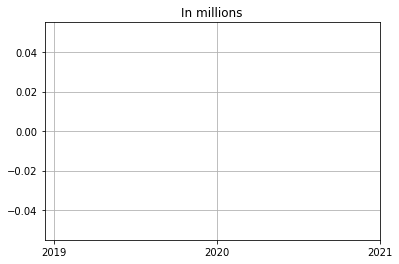

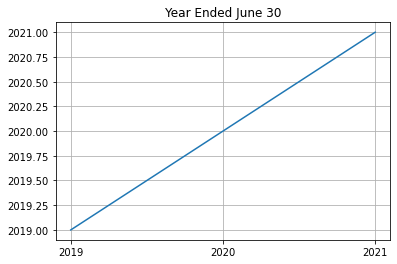

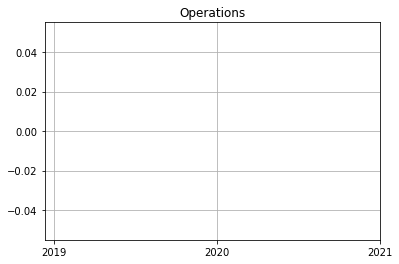

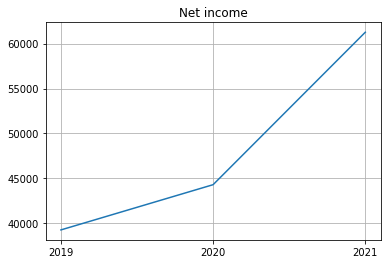

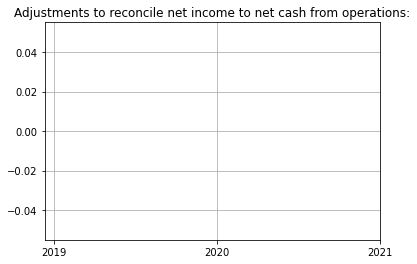

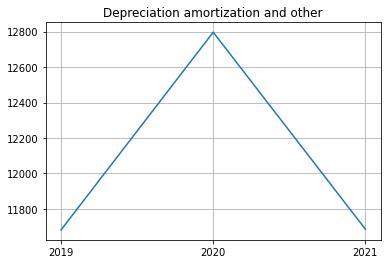

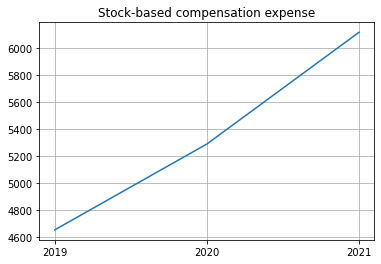

In [7]:
import matplotlib.pyplot as plt

years = ["2019", "2020", "2021"]

for item_name in cs_table["item"][:10]:
    try:
        data = [float(v) for v in cs_table.query(f"item=='{item_name}'").iloc[0, 1:]]
        plt.plot(data)
        plt.xticks([i for i in range(len(years))], years)
        plt.title(item_name)
        plt.grid()
        plt.show()
    except IndexError:
        pass